# Implementing an equation of state in python

> In `FeOs`, you can implement your equation of state in python, register it to the Rust backend, and compute properties and phase equilbria as if you implemented it in Rust.
> In this tutorial, we will implement the Peng-Robinson equation of state.

## Table of contents <a id="Table-of-contents"/>

- [Implementation](#Implementation)
- [Computing properties](#Computing-properties)
- [Critical point](#Critical-point)
- [Phase equilibria and phase diagrams](#Phase-equilibria-and-phase-diagrams)
- [Mixtures](#Mixtures)
- [Comparison to Rust implementation](#Comparison-to-Rust-implementation)

In [1]:
import feos
import si_units as si
import numpy as np

optional = True

import warnings
warnings.filterwarnings('ignore')

if optional:
    import matplotlib.pyplot as plt
    import pandas as pd
    import seaborn as sns

    sns.set_style("ticks")
    sns.set_palette("Dark2")
    sns.set_context("talk")

## Implementation <a id="Implementation"/>
[↑ Back to top](#Table-of-contents)

To implement an equation of state in python, we have to define a `class` which has to have the following methods:

```python
class MyEquationOfState:
    def helmholtz_energy(self, state: StateHD) -> D
    
    def components(self) -> int
    
    def subset(self, indices: List[int]) -> Self
    
    def molar_weight(self) -> SIArray1
    
    def max_density(self, molefracs: np.ndarray[float]) -> float
```    

- `components(self) -> int`: Returns the number of components (usually inferred from the shape of the input parameters).
- `molar_weight(self) -> SIArray1`: Returns an `SIArray1` with size equal to the number of components containing the molar mass of each component.
- `max_density(self, moles: np.ndarray[float]) -> float`: Returns the maximum allowed number density in units of `molecules/Angstrom³`.
- `subset(self, indices: List[int]) -> self`: Returns a new equation of state with parameters defined in `indices`.
- `helmholtz_energy(self, state: StateHD) -> Dual`: Returns the helmholtz energy as (hyper)-dual number given a `StateHD`.

In [2]:
SQRT2 = np.sqrt(2)

class PyPengRobinson: 
    def __init__(
        self, critical_temperature, critical_pressure, 
        acentric_factor, molar_weight, delta_ij=None
    ):
        """Peng-Robinson Equation of State
        
        Parameters
        ----------
        critical_temperature : SIArray1
            critical temperature of each component.
        critical_pressure : SIArray1
            critical pressure of each component.
        acentric_factor : np.array[float] 
            acentric factor of each component (dimensionless).
        molar_weight: SIArray1
            molar weight of each component.
        delta_ij : np.array[[float]], optional
            binary parameters. Shape=[n, n], n = number of components.
            defaults to zero for all binary interactions.
            
        Raises
        ------
        ValueError: if the input values have incompatible sizes.
        """
        self.n = len(critical_temperature)
        if len(set((
            len(critical_temperature), 
            len(critical_pressure), 
            len(acentric_factor)
        ))) != 1:
            raise ValueError("Input parameters must all have the same lenght.")
        
        self.tc = critical_temperature / si.KELVIN
        self.pc = critical_pressure / si.PASCAL
        self.omega = acentric_factor
        self.mw = molar_weight / si.GRAM * si.MOL

        self.a_r = (0.45724 * critical_temperature**2 * si.RGAS 
                    / critical_pressure / si.ANGSTROM**3 / si.NAV / si.KELVIN)
        self.b = (0.07780 * critical_temperature * si.RGAS 
                  / critical_pressure / si.ANGSTROM**3 / si.NAV)
        self.kappa = (0.37464 
                      + (1.54226 - 0.26992 * acentric_factor) * acentric_factor)
        self.delta_ij = (np.zeros((self.n, self.n)) 
                         if delta_ij is None else delta_ij)
        
    def helmholtz_energy(self, state):
        """Return helmholtz energy.
        
        Parameters
        ----------
        state : StateHD
            The thermodynamic state.
            
        Returns
        -------
        helmholtz_energy: float | any dual number
            The return type depends on the input types.
        """      
        x = state.molefracs
        tr = 1.0 / self.tc * state.temperature
        ak = ((1.0 - np.sqrt(tr)) * self.kappa + 1.0)**2 * self.a_r
        ak_mix = 0.0
        if self.n > 1:
            for i in range(self.n):
                for j in range(self.n):
                    ak_mix += (np.sqrt(ak[i] * ak[j]) 
                               * (x[i] * x[j] * (1.0 - self.delta_ij[i, j])))
        else:
            ak_mix = ak[0]
        b = np.sum(x * self.b)
        rho = np.sum(state.partial_density)
        a = rho * (-np.log(1.0 - b * rho) 
                 - ak_mix / (b * SQRT2 * 2.0 * state.temperature) 
                 * np.log((1.0 + (1.0 + SQRT2) * b * rho) / (1.0 + (1.0 - SQRT2) * b * rho)))
        return a
    
    def components(self) -> int: 
        """Number of components."""
        return self.n
    
    def subset(self, i: list[int]):
        """Return new equation of state containing a subset of all components."""
        if self.n > 1:
            tc = self.tc[i] 
            pc = self.pc[i]
            mw = self.mw[i]
            omega = self.omega[i]
            return PyPengRobinson(
                si.array(tc * si.KELVIN), 
                si.array(pc * si.PASCAL), 
                omega, 
                si.array(mw * si.GRAM / si.MOL)
            )
        else:
            return self
        
    def molar_weight(self) -> si.SIObject:
        return si.array(self.mw * si.GRAM / si.MOL)
    
    def max_density(self, molefracs: list[float]) -> float:
        b = np.sum(molefracs * self.b)
        return 0.9 / b 

## Computing properties <a id="Computing-properties"/>
[↑ Back to top](#Table-of-contents)

Let's compute some properties. First, we have to instanciate the class and register it to Rust.
This is done using the `EquationOfState.python` method.

In [3]:
tc = si.array(369.96 * si.KELVIN)
pc = si.array(4250000.0 * si.PASCAL)
omega = np.array([0.153])
molar_weight = si.array(44.0962 * si.GRAM / si.MOL)

# create an instance of our python class and hand it over to rust
pr = PyPengRobinson(tc, pc, omega, molar_weight)
eos = feos.EquationOfState.python_residual(pr)

### Thermodynamic state: the `State` object

Before we can compute a property, we create a `State` object. This can be done in several ways depending on what control variables we need.
If no total amount of substance is defined, it is set to $n = \frac{1}{N_{AV}}$.
For possible input combinations, you can inspect the signature of the constructor using `State?`.

In [4]:
feos.State?

Init signature:
feos.State(
    eos,
    temperature=None,
    volume=None,
    density=None,
    partial_density=None,
    total_moles=None,
    moles=None,
    molefracs=None,
    pressure=None,
    molar_enthalpy=None,
    molar_entropy=None,
    molar_internal_energy=None,
    density_initialization=None,
    initial_temperature=None,
)
Docstring:     
A thermodynamic state at given conditions.

Parameters
----------
eos : Eos
    The equation of state to use.
temperature : SINumber, optional
    Temperature.
volume : SINumber, optional
    Volume.
density : SINumber, optional
    Molar density.
partial_density : SIArray1, optional
    Partial molar densities.
total_moles : SINumber, optional
    Total amount of substance (of a mixture).
moles : SIArray1, optional
    Amount of substance for each component.
molefracs : numpy.ndarray[float]
    Molar fraction of each component.
pressure : SINumber, optional
    Pressure.
molar_enthalpy : SINumber, optional
    Molar enthalpy.
molar_

If we use input variables other than $\mathbf{N}, V, T$ (the natural variables of the Helmholtz energy), creating a state is an iterative procedure.
For example, we can create a state for a give $T, p$, which will result in a iteration of the volume (density).

In [5]:
# If no amount of substance is given, it is set to 1/NAV.
s = feos.State(eos, temperature=300*si.KELVIN, pressure=1*si.BAR)
s.total_moles

1.6605390671738466e-24  mol

In [6]:
s_pt = feos.State(
    eos, 
    temperature=300*si.KELVIN, 
    pressure=1*si.BAR, 
    total_moles=1*si.MOL
)
s_pt.total_moles

1  mol

## Critical point <a id="Critical-point"/>
[↑ Back to top](#Table-of-contents)

To generate a state at critical conditions, we can use the `critical_point` constructor.

In [7]:
s_cp = feos.State.critical_point(eos)
print("Critical point")
print("temperature: ", s_cp.temperature)
print("density    : ", s_cp.mass_density())
print("pressure   : ", s_cp.pressure())

Critical point
temperature:  369.9506174234607 K
density    :  198.1862458057178 kg/m³
pressure   :  4.249677749116937 MPa


## Phase equilibria and phase diagrams<a id="Phase-equilibria-and-phase-diagrams"/>
[↑ Back to top](#Table-of-contents)

We can also create an object, `PhaseEquilibrium`, that contains states that are in equilibrium.

In [8]:
vle = feos.PhaseEquilibrium.pure(eos, 300.0*si.KELVIN)
vle

||temperature|density|
|-|-|-|
|phase 1|300.00000 K|488.99014  mol/m³|
|phase 2|300.00000 K|11.53399 kmol/m³|


Each phase is a `State` object. We can simply access these states and compute properties, just like before.

In [9]:
vle.liquid # the high density phase `State`

|temperature|density|
|-|-|
|300.00000 K|11.53399 kmol/m³|

In [10]:
vle.vapor # the low density phase `State`

|temperature|density|
|-|-|
|300.00000 K|488.99014  mol/m³|

In [11]:
# we can now easily compute any property:
print("Heat of vaporization: ", vle.vapor.molar_enthalpy(feos.Contributions.Residual) - vle.liquid.molar_enthalpy(feos.Contributions.Residual))
print("for T = {}".format(vle.liquid.temperature))
print("and p = {:.2f} bar".format(vle.liquid.pressure() / si.BAR))

Heat of vaporization:  14.782343503305126 kJ/mol
for T = 300 K
and p = 9.95 bar


We can also easily compute **vapor pressures** and **boiling temperatures**:

In [12]:
# This also works for mixtures, in which case the pure component properties are computed.
# Hence, the result is a list - that is why we use an index [0] here.
print("vapor pressure      (T = 300 K):", feos.PhaseEquilibrium.vapor_pressure(eos, 300*si.KELVIN)[0])
print("boiling temperature (p = 3 bar):", feos.PhaseEquilibrium.boiling_temperature(eos, 2*si.BAR)[0])

vapor pressure      (T = 300 K): 994.7761635610095 kPa
boiling temperature (p = 3 bar): 247.84035574956758 K


### Phase Diagram

We could repeatedly compute `PhaseEquilibrium` states for different temperatures / pressures to generate a phase diagram.
Because this a common task, there is a object for that as well.

The `PhaseDiagram` object creates multiple `PhaseEquilibrium` objects (`npoints` of those) between a given lower temperature and the critical point.

In [13]:
dia = feos.PhaseDiagram.pure(eos, 230.0 * si.KELVIN, 500)

We can access each `PhaseEquilbrium` and then conveniently comput any property we like:

In [14]:
enthalpy_of_vaporization = [
    (vle.vapor.molar_enthalpy(feos.Contributions.Residual) - vle.liquid.molar_enthalpy(feos.Contributions.Residual)) / (si.KILO * si.JOULE) * si.MOL 
    for vle in dia.states
]

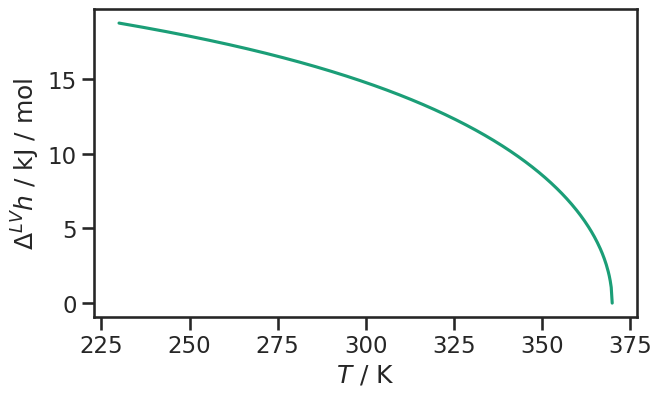

In [15]:
fig, ax = plt.subplots(figsize=(7, 4))
sns.lineplot(x=dia.vapor.temperature / si.KELVIN, y=enthalpy_of_vaporization, ax=ax);
ax.set_ylabel(r"$\Delta^{LV}h$ / kJ / mol")
ax.set_xlabel(r"$T$ / K");

A more convenient way is to create a dictionary. The dictionary can be used to build pandas `DataFrame` objects.
This is a bit less flexible, because the units of the properties are rigid. You can inspect the method signature to check what units are used.

In [16]:
dia.to_dict?

Signature: dia.to_dict(contributions)
Docstring:
Returns the phase diagram as dictionary.

Parameters
----------
contributions : Contributions, optional
    The contributions to consider when calculating properties.
    Defaults to Contributions.Total.

Returns
-------
Dict[str, List[float]]
    Keys: property names. Values: property for each state.

Notes
-----
- temperature : K
- pressure : Pa
- densities : mol / m³
- mass densities : kg / m³
- molar enthalpies : kJ / mol
- molar entropies : kJ / mol / K
- specific enthalpies : kJ / kg
- specific entropies : kJ / kg / K
- xi: liquid molefraction of component i
- yi: vapor molefraction of component i
- component index `i` matches to order of components in parameters.
Type:      builtin_function_or_method

In [17]:
data_dia = pd.DataFrame(dia.to_dict(feos.Contributions.Residual))
data_dia.head()

,temperature,pressure,density liquid,density vapor,molar enthalpy liquid,molar enthalpy vapor,molar entropy liquid,molar entropy vapor,mass density liquid,mass density vapor,specific enthalpy liquid,specific enthalpy vapor,specific entropy liquid,specific entropy vapor
0,230.000000,96625.278174,14125.988947,52.208491,-18.921555,-0.157448,-0.035166,-0.000148,622.902434,2.302196,-429.097170,-3.570554,-0.797483,-0.003363
1,230.280462,97830.133956,14118.006852,52.811929,-18.911909,-0.159193,-0.035119,-0.000150,622.550454,2.328805,-428.878435,-3.610123,-0.796418,-0.003399
2,230.560924,99046.729400,14110.010220,53.420767,-18.902255,-0.160952,-0.035072,-0.000152,622.197833,2.355653,-428.659501,-3.650021,-0.795354,-0.003436
3,230.841386,100275.143120,14101.999011,54.035036,-18.892592,-0.162726,-0.035025,-0.000153,621.844569,2.382740,-428.440366,-3.690251,-0.794290,-0.003473
4,231.121849,101515.453964,14093.973182,54.654773,-18.882920,-0.164515,-0.034978,-0.000155,621.490660,2.410068,-428.221030,-3.730814,-0.793228,-0.003510


Once we have a dataframe, we can store our results or create a nicely looking plot:

In [18]:
def phase_plot(data, x, y):
    fig, ax = plt.subplots(figsize=(12, 6))
    if x != "pressure" and x != "temperature":
        xl = f"{x} liquid"
        xv = f"{x} vapor"
    else:
        xl = x
        xv = x
    if y != "pressure" and y != "temperature":
        yl = f"{y} liquid"
        yv = f"{y} vapor"
    else:
        yv = y
        yl = y
    sns.lineplot(data=data, x=xv, y=yv, ax=ax, label="vapor")
    sns.lineplot(data=data, x=xl, y=yl, ax=ax, label="liquid")
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.legend(frameon=False)
    sns.despine();

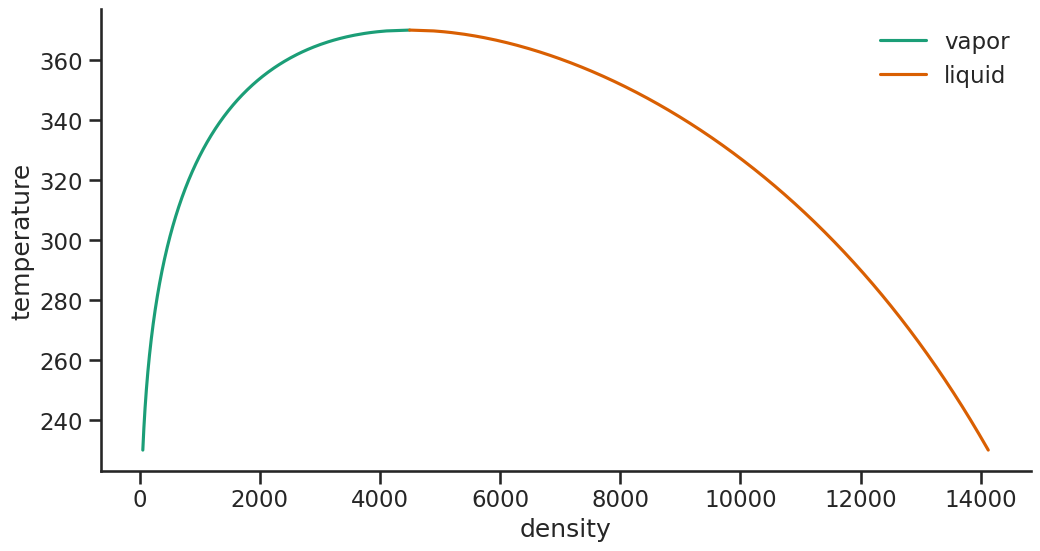

In [19]:
phase_plot(data_dia, "density", "temperature")

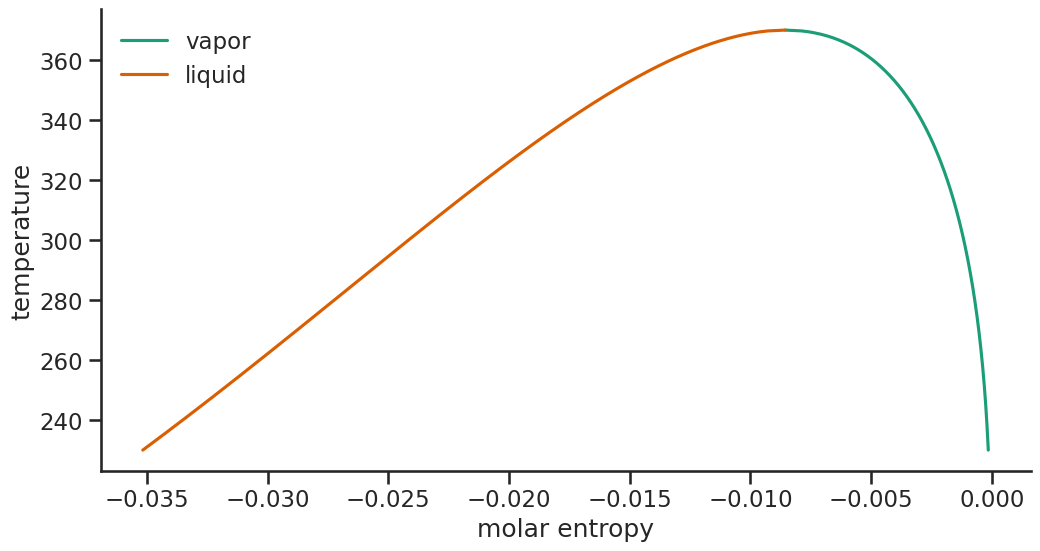

In [20]:
phase_plot(data_dia, "molar entropy", "temperature")

## Mixtures <a id="Mixtures"/>
[↑ Back to top](#Table-of-contents)

Fox mixtures, we have to add information about the composition, either as molar fraction, amount of substance per component, or as partial densities.

In [21]:
# propane, butane mixture
tc = np.array([369.96, 425.2]) * si.KELVIN
pc = np.array([4250000.0, 3800000.0]) * si.PASCAL
omega = np.array([0.153, 0.199])
molar_weight = np.array([44.0962, 58.123]) * si.GRAM / si.MOL

pr = PyPengRobinson(tc, pc, omega, molar_weight)
eos = feos.EquationOfState.python_residual(pr)

In [22]:
s = feos.State(
    eos, 
    temperature=300*si.KELVIN, 
    pressure=1*si.BAR, 
    molefracs=np.array([0.5, 0.5]), 
    total_moles=si.MOL
)
s

|temperature|density|molefracs
|-|-|-|
|300.00000 K|40.96869  mol/m³|[0.50000, 0.50000]|

As before, we can compute properties by calling methods on the `State` object. Some return vectors or matrices - for example the chemical potential and its derivative w.r.t amount of substance:

In [23]:
s.chemical_potential(feos.Contributions.Residual)

array([ -93.60749754, -120.5269973 ]) J/mol

In [24]:
s.dmu_dni() / (si.KILO * si.JOULE / si.MOL**2)

array([[ 4.90721995, -0.10487987],
       [-0.10487987,  4.85361765]])

Phase equilibria can be built from different constructors. E.g. at critical conditions given composition:

In [25]:
s_cp = feos.State.critical_point(eos, molefracs=np.array([0.5, 0.5]))
s_cp

|temperature|density|molefracs
|-|-|-|
|401.65562 K|3.99954 kmol/m³|[0.50000, 0.50000]|

Or at given temperature (or pressure) and composition for bubble and dew points.

In [26]:
vle = feos.PhaseEquilibrium.bubble_point(
    eos, 
    350*si.KELVIN, 
    liquid_molefracs=np.array([0.5, 0.5])
)
vle

||temperature|density|molefracs|
|-|-|-|-|
|phase 1|350.00000 K|879.50373  mol/m³|[0.67631, 0.32369]|
|phase 2|350.00000 K|8.96383 kmol/m³|[0.50000, 0.50000]|


Similar to pure substance phase diagrams, there is a constructor for binary systems.

In [27]:
vle = feos.PhaseDiagram.binary_vle(eos, 350*si.KELVIN, npoints=50)

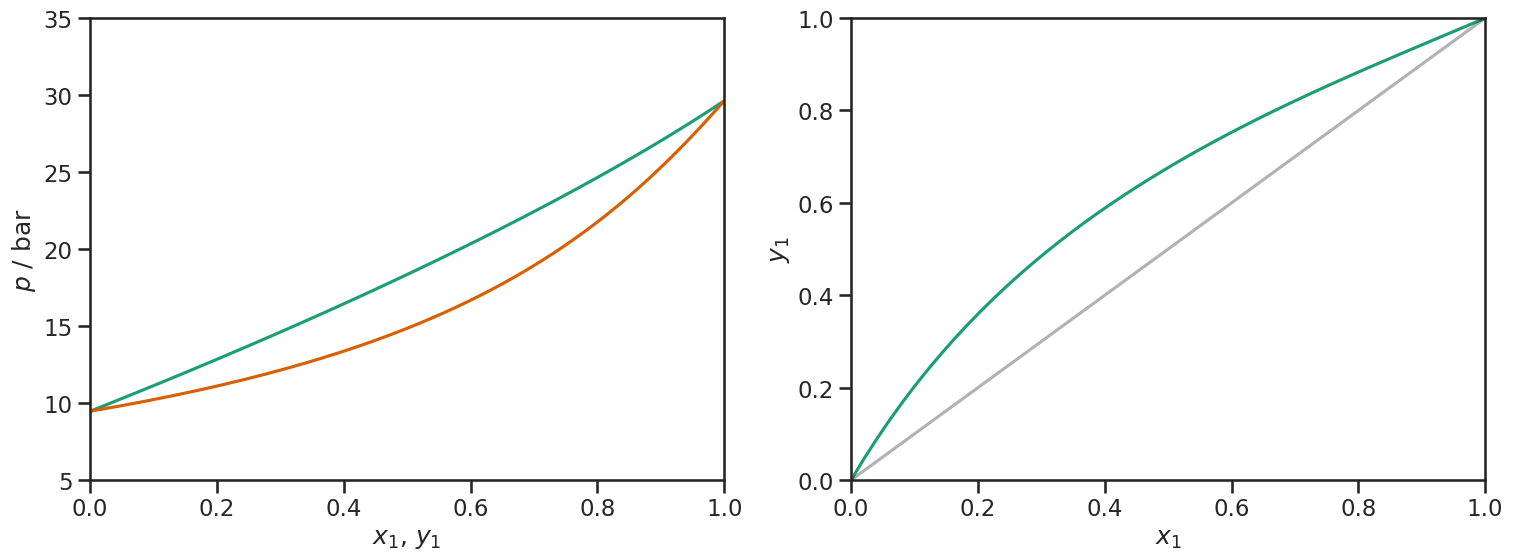

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
# fig.title("T = 350 K, Propane (1), Butane (2)")
sns.lineplot(x=vle.liquid.molefracs[:,0], y=vle.liquid.pressure / si.BAR, ax=ax[0])
sns.lineplot(x=vle.vapor.molefracs[:,0], y=vle.vapor.pressure / si.BAR, ax=ax[0])
ax[0].set_xlabel(r"$x_1$, $y_1$")
ax[0].set_ylabel(r"$p$ / bar")
ax[0].set_xlim(0, 1)
ax[0].set_ylim(5, 35)
# ax[0].legend(frameon=False);

sns.lineplot(x=vle.liquid.molefracs[:,0], y=vle.vapor.molefracs[:,0], ax=ax[1])
sns.lineplot(x=np.linspace(0, 1, 10), y=np.linspace(0, 1, 10), color="black", alpha=0.3, ax=ax[1])
ax[1].set_xlabel(r"$x_1$")
ax[1].set_ylabel(r"$y_1$")
ax[1].set_xlim(0, 1)
ax[1].set_ylim(0, 1);

## Comparison to Rust implementation <a id="Comparison-to-Rust-implementation"/>
[↑ Back to top](#Table-of-contents)

Implementing an equation of state in Python is nice for quick prototyping and development but when it comes to performance, implementing the equation of state in Rust is the way to go.
For each non-cached call to the Helmholtz energy, we have to transition between Rust and Python with our Python implementation which generates quite some overhead.

Here are some comparisons between the Rust and our Python implemenation:

In [29]:
# rust
eos_rust = feos.EquationOfState.peng_robinson(feos.Parameters.from_json(["propane"], "../../../examples/data/peng-robinson.json"))

# python
tc = si.array(369.96 * si.KELVIN)
pc = si.array(4250000.0 * si.PASCAL)
omega = np.array([0.153])
molar_weight = si.array(44.0962 * si.GRAM / si.MOL)
eos_python = feos.EquationOfState.python_residual(PyPengRobinson(tc, pc, omega, molar_weight))

In [30]:
# let's first test if both actually yield the same results ;)
assert abs(feos.State.critical_point(eos_python).pressure() / si.BAR - feos.State.critical_point(eos_rust).pressure() / si.BAR) < 1e-12
assert abs(feos.State.critical_point(eos_python).temperature / si.KELVIN - feos.State.critical_point(eos_rust).temperature / si.KELVIN) < 1e-12

In [31]:
import timeit

time_python = timeit.timeit(lambda: feos.State.critical_point(eos_python), number=2_500)
time_rust = timeit.timeit(lambda: feos.State.critical_point(eos_rust), number=2_500)

In [32]:
rel_dev = (time_rust - time_python) / time_rust
print(f"Critical point for pure substance")
print(f"Python implementation is {'slower' if rel_dev < 0 else 'faster'} by a factor of {abs(time_python / time_rust):.0f}.")

Critical point for pure substance
Python implementation is slower by a factor of 24.


In [33]:
time_python = timeit.timeit(lambda: feos.PhaseDiagram.pure(eos_python, 300*si.KELVIN, 100), number=100)
time_rust = timeit.timeit(lambda: feos.PhaseDiagram.pure(eos_rust, 300*si.KELVIN, 100), number=100)

In [34]:
rel_dev = (time_rust - time_python) / time_rust
print(f"Phase diagram for pure substance")
print(f"Python implementation is {'slower' if rel_dev < 0 else 'faster'} by a factor of {abs(time_python / time_rust):.0f}.")

Phase diagram for pure substance
Python implementation is slower by a factor of 80.
